# DQN using Pytorch

Basically copied from the dqn_tutorial-pytorch but adapted for our environment

In [106]:
import numpy as np
import gym
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import time
import matplotlib.pyplot as plt

In [107]:
env = gym.make('Acrobot-v1')

## Creating the Deep Neural Network

In [108]:
class Q_Network(nn.Module):
    def __init__(self, state_dim , action_dim):
        super(Q_Network, self).__init__()
        self.x_layer = nn.Linear(state_dim, 30)
        self.h_layer = nn.Linear(30, 16)
        self.y_layer = nn.Linear(16, action_dim)
        print(self.x_layer)

    def forward(self, state):
        xh = F.relu(self.x_layer(state))
        hh = F.relu(self.h_layer(xh))
        state_action_values = self.y_layer(hh)
        return state_action_values

## Making the Agent

In [109]:
class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        self.qnet = Q_Network(state_dim, action_dim)
        self.qnet_optim = torch.optim.Adam(self.qnet.parameters(), lr=0.001)
        self.discount_factor = 0.99
        self.MSELoss_function = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()
        pass
    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
                return env.action_space.sample()  # choose random action
        else:
                network_output_to_numpy = self.qnet(state).data.numpy()
                return np.argmax(network_output_to_numpy)  # choose greedy action

    def update_Q_Network(self, state, next_state, action, reward, terminals):
        
        qsa = torch.gather(self.qnet(state), dim=1, index=action.long())
        qsa_next_action = self.qnet(next_state)
        # print(qsa)
        # print(qsa_next_action)
        qsa_next_action,_ = torch.max(qsa_next_action, dim=1, keepdim=True)
        not_terminals = 1 - terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * qsa_next_action
        # print(qsa_next_target)
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
        
    
        
    def update(self, update_rate):
        for i in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample_minibatch(64)
            states = torch.Tensor(states)
            next_states = torch.Tensor(next_states)
            actions = torch.Tensor(actions)
            rewards = torch.Tensor(rewards)
            terminals = torch.Tensor(terminals)
            self.update_Q_Network(states, next_states, actions, rewards, terminals)
        
    
    def best_move(self, state):
        
        return np.argmax(self.qnet(state).data.numpy())

In [110]:
class ReplayBuffer(object):
    def __init__(self):
        self.buffer = []
        
    def add_to_buffer(self, data):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer.append(data)
        

    def sample_minibatch(self,minibatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for i in range(minibatch_length):
            random_int = np.random.randint(0, len(self.buffer)-1) 
            transition = self.buffer[random_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            rewards.append(transition[3])
            terminals.append(transition[4])
        return torch.Tensor(states), torch.Tensor(next_states), torch.Tensor(actions), torch.Tensor(rewards), torch.Tensor(terminals)



In [111]:
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]


# Deep Q Learning

In [112]:
agent = DQNAgent(state_dim, action_dim)
number_of_episodes = 500
reward_list = []
epsilon = 1
finals = []


for episode in range(number_of_episodes):
    reward_sum = 0
    state = env.reset()
    state = np.array(state[0])
    done = False
    print(episode)

    while not done:
        action = agent.epsilon_greedy_action(torch.from_numpy(state).float() , epsilon)
        # print(action)
        next_state, reward, terminated,truncated, _ = env.step(action)
        done = truncated or terminated
        reward_sum += reward
        agent.replay_buffer.add_to_buffer((state,next_state,[action],[reward],[done]))
        
        state = next_state
        if done:
            clear_output(wait=True)
            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
            reward_list.append(reward_sum)
            finals.append(reward)
            break
    
    agent.update(128)
    
    if epsilon > 0.2:
        epsilon *= 0.995 #Epsilon decay
    
    if epsilon <= 0.2:
        epsilon = 0.2

episode: 499 sum_of_rewards_for_episode: -103.0


In [113]:
def m_a(values, window=50):
    weight = np.repeat(1.0, window)/window
    smas = np.convolve(values,weight,'valid')
    return smas

In [114]:
smas_ = m_a(reward_list)
np.where(smas_> 100)


(array([], dtype=int64),)

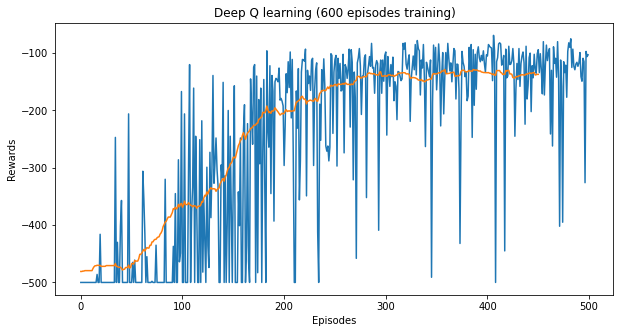

In [115]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(reward_list)
ax.plot(smas_)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes')
ax.set_title('Deep Q learning (600 episodes training)')
plt.savefig('DQN600epma', transparent=True)

# Visualise the Model

In [116]:
# state = env.reset()

# while True:
    
#     env.render()
#     action = agent.best_move(torch.from_numpy(state).float())
    
#     next_state, _, terminal, _ = env.step(action)
    
#     state = next_state
    
#     if terminal:
#         break
    
# env.close()